# FEATURE SELECTION
The purpose of this jupyter notebook is to exemplify how feature selection was accomplished.   

Feature selection for categorical fields used the Mutual Information method and feature selection for continuous fields used the ANOVA method. Cross-validation was used to identify the most optimal value for k in both methods.   

The first part of the notebook runs a few processes from main.py in order to create the data needed for feature selection. Parts of Step 2 is used to create the `ec_data2` dataframe and parts of Step 3 is used to merge `ec_data2` with metadata csv and training set csv to create the `merged_outer` dataframe.

**Limitations**
* The process of feature selection is not dynamic in main.py. The reason is we had to implement two separate feature selection techniques for categorical and continuous data. We had to remove unique sensor ID for categorical feature selection and for that reason we were unable to join back continous data. 

**Future Work**  
To apply feature selection for future buildings, it is recommended to:
* Update QUERY_SITE variable, metadata csv, and training set csv if applicable
* Modify `data_preparation.equip_label()` and `data_preparation.nav_label()` functions to capture additional categorical levels if "NEED_TO_LABEL" is outputted as a recommended categorical feature 

### Library Imports

In [1]:
### ~ Library Imports ~ ###
# General Imports
from os import listdir
from os.path import isfile, join
from datetime import datetime, date, timedelta
# Data Formatting and Manipulation Imports
import pandas as pd
import numpy as np
# Feature Selection Imports
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV, SelectKBest, f_classif, mutual_info_classif
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
# Clustering Step Imports
from sklearn.cluster import AgglomerativeClustering
# Regression Step Imports
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
# Modules Developed for this Project Imports
import data_preparation
import aggregation
import clustering

### Running Parts of Steps 2 and Step 3 from main.py

In [2]:
#############################################################################################
################################## SETTTING CONSTANTS #######################################
#############################################################################################

### ~ Required for base functionality ~ ###
# String defining which site to run the model for
QUERY_SITE = 'Pharmacy'
# String defining which measurement from the database to query
MEASUREMENT='UBC_EWS'
# String defining the path to the metadata csv for the given building
METADATA_CSV_PATH = '../data/PharmacyQuery.csv'
# String defining the path to the training dataset
TRAINING_SET_PATH = '../data/pharmacy_train_test_data.csv'
# List of indices that can be combined to uniquely identify a sensor (used to group on each sensors)
SENSOR_ID_TAGS = [1,2,3,4,5,6] # order is ["groupRef","equipRef","navName","siteRef","typeRef","unit"]
                               # The planned update to the InfluxDB may change SENSOR_ID_TAGS to only [1] as in ["uniqueID"]
### ~ Alows customization of outputs ~ ###
# Boolean defining if the output dataframes from each step should be saved (save if True, else False)
SAVE_STEP_OUTPUTS = True
# Strings defining the location to save the dataframe csv's
STEP1_SAVE_PATH = '../data/csv_outputs/step1_clustering_phase_output.csv'
STEP2_SAVE_PATH_FINAL_DF = '../data/csv_outputs/step2_ridge_regression_output.csv'
STEP2_SAVE_PATH_EC_DATA2 = '../data/csv_outputs/step2_aggregated_ec_data_output.csv'
# Boolean defining if the model should query from the database or pull from csv's (from database if True, else False)
QUERY_FROM_DB = True
# Strings defining the start and end date fo the date range to query (if QUERY_FROM_DB==True)
START_DATE = '2020-06-01'
END_DATE = '2020-06-05'
# Strings containing the paths to the folders that contains the csv's to pull data from if QUERY_FROM_DB==False
# All file names within the folders must be formatted as "YYYY-MM-DD.csv"
QUERY_CSV_PATH = '../data/sensor_data/'
QUERY_WEATHER_CSV_PATH = '../data/weather_data/'

if QUERY_FROM_DB:
    # Generating a list of the dates within the daterange to query (if QUERY_FROM_DB==True)
    DELTA = (datetime.strptime(END_DATE, "%Y-%m-%d")-datetime.strptime(START_DATE, "%Y-%m-%d")).days
    DATELIST =  [(datetime.strptime(END_DATE, "%Y-%m-%d") - timedelta(days=x)).strftime('%Y-%m-%d') for x in range(0,DELTA+1)]
else:
    # Getting the list of files stored in the path provided in QUERY_CSV_PATH
    # All files names must be formatted as "YYYY-MM-DD.csv"
    DATELIST = [f.split(".")[0] for f in listdir(QUERY_CSV_PATH) if isfile(join(QUERY_CSV_PATH, f))]

# Connecting to influxDB
if QUERY_FROM_DB:
    client = data_preparation.connect_to_db()


#############################################################################################
############################### STEP 2) Model EC/NC  ########################################
#############################################################################################

print("####### ~~~~~ Starting - Step 2: Model EC/NC Relationship ~~~~~ #######") # For tracking program progress
###   a) Aggregate EC sensors to be response variables for the regression model
print("\t##### ~~~ Started - Step 2 a): Aggregation ~~~ #####") # For tracking program progress
last_idx_as_cols = False
is_first_iter = True
cnt=1
for day in DATELIST:
    print("\t\t"+str(cnt)+": "+str(day)) # For tracking program progress
    # Querying and preping data for aggregations
    if QUERY_FROM_DB:
        temp_df2 = data_preparation.query_db_ec(client, day, measurement=MEASUREMENT, num_days=1, site=QUERY_SITE)
        if temp_df2 is not None:
            # Making the datetime index into a column so that date and hour can be extracted later
            temp_df2.reset_index(level=0, inplace=True)
    else:
        temp_df2 = data_preparation.query_csv(client=QUERY_CSV_PATH, date=day, site=None)
        # Filter for EC data, this step will be done in the query
        if temp_df2 is not None:
            temp_df2=temp_df2[(temp_df2['unit']=='kWh') | (temp_df2['unit']=='m³')]
    if temp_df2 is None:
        continue
    col_names = ['datetime']
    col_names.extend(temp_df2.columns[1:])
    temp_df2.columns = col_names
    temp_df2 = aggregation.split_datetime(temp_df2)
    # Creating uniqueId
    temp_df2=data_preparation.create_unique_id(temp_df2)
    # Filtering dataframe for only relevant fields
    temp_df2=temp_df2[['uniqueId', 'date', 'hour', 'unit', 'value']]
    if is_first_iter:
        # Creating a low memory dataframe for the append_agg function before the structure is changed by agg_all
        struct_df2 = temp_df2.head(1)
        # Aggregating the first date's data
        ec_data1=aggregation.agg_numeric_by_col(temp_df2, col_idx=[0,1,2,3], how='mean')
        # Also create second DF by aggregating further just using sensor ID fields (end result=1row per sensor)
        ec_data2=aggregation.agg_numeric_by_col(temp_df2, col_idx=[0,3], how='all')
        is_first_iter = False
    else:
        # Aggregating the current date's data and aggregate it with the current running total
        temp_df2a=aggregation.agg_numeric_by_col(temp_df2, col_idx=[0,1,2,3], how='mean')
        temp_df2b=aggregation.agg_numeric_by_col(temp_df2, col_idx=[0,3], how='all')
        ec_data1=aggregation.append_agg(df1=temp_df2a, df2=ec_data1, struct_df=struct_df2, col_idx=[0,1,2,3])
        ec_data2=aggregation.append_agg(df1=temp_df2b, df2=ec_data2, struct_df=struct_df2, col_idx=[0,3])
    cnt += 1
# Freeing up some memory
temp_df2 = None
temp_df2a = None
temp_df2b = None
# Calculating the update rate
ec_data2["update_rate"] = ec_data2["count"] / (cnt*24)
ec_data2.drop("count", inplace=True, axis=1)

# Resetting index columns
ec_data2=ec_data2.reset_index()

if SAVE_STEP_OUTPUTS:
    ec_data2.to_csv(STEP2_SAVE_PATH_EC_DATA2)

print("####### ~~~~~ Complete - Step 2: Model EC/NC Relationship ~~~~~ #######") # For tracking program progress

    
#############################################################################################
#################### STEP 3) Prep EC data for classification model  #########################
#############################################################################################

print("####### ~~~~~ Starting - Step 3: Prep EC Data for Classification Model ~~~~~ #######") # For tracking program progress
###   a) Load metadata and join with 2b_EC_data_df
metadata=pd.read_csv(METADATA_CSV_PATH, dtype=object)
# Make uniqueIDs
metadata=data_preparation.create_unique_id(metadata, metadata=True)
# Drop duplicates
metadata=metadata.sort_values('lastSynced').drop_duplicates('uniqueId',keep='last')
# Choose relevant fields
metadata=metadata[['uniqueId','kind', 'energy','power', 'sensor', 'unit', 'water']]
# Changing boolean to easily identify during encoding process
metadata['energy']=metadata['energy'].apply(lambda x: 'yes_energy' if x=='✓' else 'no_energy')
metadata['power']=metadata['power'].apply(lambda x: 'yes_power' if x=='✓' else 'no_power')
metadata['sensor']=metadata['sensor'].apply(lambda x: 'yes_sensor' if x=='✓' else 'no_sensor')
metadata['water']=metadata['water'].apply(lambda x: 'yes_water' if x=='✓' else 'no_water')
metadata['unit']=metadata['unit'].apply(lambda x: 'omit' if x=='_' else x)
# left join metadata and 2b_EC_data_df
merged_left=pd.merge(ec_data2, metadata, how='left', left_on='uniqueId', right_on='uniqueId')

###   b) Apply feature selection function(s) to the joined EC+metadata
# load end_use classifications training data
end_use_labels=pd.read_csv(TRAINING_SET_PATH)
# make uniqueId
end_use_labels['siteRef']=QUERY_SITE
end_use_labels=data_preparation.create_unique_id(end_use_labels)

# rename columns to fix unit of measurements
end_use_labels.rename(columns={'UBC_EWS.firstValue':'value'}, inplace=True)
# run correct_df_units function
end_use_labels=data_preparation.correct_df_units(end_use_labels)

# TRAINING DATA CLEANING
# Change ? to 0 since uom fixed
end_use_labels=end_use_labels.assign(isGas=end_use_labels.isGas.apply(lambda x: '0' if x=='?' else x))
# changing boolean for more descriptive encoding
end_use_labels=end_use_labels.assign(isGas=end_use_labels.isGas.apply(lambda x: 'no_gas' if x=='0' else 'yes_gas'))

# selecting relevant training data fields
end_use_labels=end_use_labels[['uniqueId', 'isGas', 'equipRef', 'groupRef', 'navName', 'endUseLabel']]
end_use_labels=end_use_labels.drop_duplicates()
merged_outer=pd.merge(left=merged_left, right=end_use_labels, how='left', left_on='uniqueId', right_on='uniqueId')
# make equipRef and navName into smaller categories for feature engineering
merged_outer=merged_outer.assign(equipRef=merged_outer.equipRef.apply(lambda x: data_preparation.equip_label(str(x))))
merged_outer=merged_outer.assign(navName=merged_outer.navName.apply(lambda x: data_preparation.nav_label(str(x))))

Successful Connection to SKYSPARK

####### ~~~~~ Starting - Step 2: Model EC/NC Relationship ~~~~~ #######
	##### ~~~ Started - Step 2 a): Aggregation ~~~ #####
		1: 2020-06-05
		2: 2020-06-04
		3: 2020-06-03
		4: 2020-06-02
		5: 2020-06-01
####### ~~~~~ Complete - Step 2: Model EC/NC Relationship ~~~~~ #######
####### ~~~~~ Starting - Step 3: Prep EC Data for Classification Model ~~~~~ #######


### CATEGORICAL FEATURE SELECTION

Optimal number of features : 9


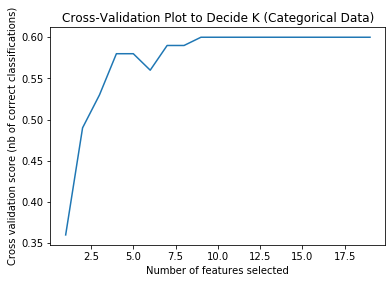

Original number of features: 19

These are the 9 recommended categorical features:

['energy_no_energy', 'energy_yes_energy', 'sensor_no_sensor', 'sensor_yes_sensor', 'equipRef_Air_Equip', 'equipRef_Cooling', 'equipRef_Heating', 'equipRef_LEED', 'navName_Energy']



In [3]:
##########################################################################
####################### CATEGORICAL FEATURE SELECTION ####################
##########################################################################
categorical=merged_outer[['energy', 'power', 'sensor', 'unit', 'water', 'isGas', 'equipRef', 'navName', 'endUseLabel']].copy()
categorical=categorical[(categorical['unit']=='kWh') | (categorical['unit']=='m³')]
categorical=categorical.drop(['unit'], axis=1)

##########################################################################
###################### Preprocessing of Data #############################
##########################################################################
#### Split data into training and test data
dataset = categorical.values
X = dataset[:, :-1]
y = dataset[:,-1]
X=X.astype(str)
y=y.astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.42, random_state=1)

#### Encode categorical data
oe = OneHotEncoder(handle_unknown='ignore')
oe.fit(X_train)
X_train_enc = oe.transform(X_train)
X_test_enc = oe.transform(X_test)

le = LabelEncoder()
le.fit(y_train)
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)
##########################################################################
################### Done with Preprocessing of Data ######################
##########################################################################



##########################################################################
############# Choosing K=max_feature through Cross-Validation #############
##########################################################################

### Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
### The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X_train_enc, y_train_enc)

### Create dataframe with scroes and number of features
Scores=pd.DataFrame({'scores':rfecv.grid_scores_,'num_features':range(1, len(rfecv.grid_scores_) + 1)})

### Choosing max number of features depending on how many features are recommended
max_feature=rfecv.n_features_

print("Optimal number of features : %d" % rfecv.n_features_)

##### Plot Cross-Validation Scores and Number of Features
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.title("Cross-Validation Plot to Decide K (Categorical Data)")
plt.show()    
##########################################################################
###################### Done with Cross-Validation ########################
##########################################################################


##########################################################################
###########  Mutual Information Technique using K=max_feature #############
##########################################################################
fs = SelectKBest(score_func=mutual_info_classif, k=int(max_feature))
fs.fit(X_train_enc, y_train_enc)
X_train_fs = fs.transform(X_train_enc)
X_test_fs = fs.transform(X_test_enc)

### Storing all feature labels
all_feature_names=oe.get_feature_names()
all_features_count=len(all_feature_names)

### Storing recommended feature labels
fs.get_support(indices=True)
feature_names = [all_feature_names[i] for i in fs.get_support(indices=True)]
if feature_names:
    feature_names = np.asarray(feature_names)

### Modifying feature labels to include original field names
new_feature_names=[]
for i in range(len(categorical.columns)+1):
    if feature_names[i][1:2]==str(0):
        new_feature_names.append(feature_names[i].replace(feature_names[i][:2], categorical.columns[0]))
    elif feature_names[i][1:2]==str(1):
        new_feature_names.append(feature_names[i].replace(feature_names[i][:2], categorical.columns[1]))
    elif feature_names[i][1:2]==str(2):
        new_feature_names.append(feature_names[i].replace(feature_names[i][:2], categorical.columns[2]))
    elif feature_names[i][1:2]==str(3):
        new_feature_names.append(feature_names[i].replace(feature_names[i][:2], categorical.columns[3]))
    elif feature_names[i][1:2]==str(4):
        new_feature_names.append(feature_names[i].replace(feature_names[i][:2], categorical.columns[4]))
    elif feature_names[i][1:2]==str(5):
        new_feature_names.append(feature_names[i].replace(feature_names[i][:2], categorical.columns[5]))
    elif feature_names[i][1:2]==str(6):
        new_feature_names.append(feature_names[i].replace(feature_names[i][:2], categorical.columns[6]))
    elif feature_names[i][1:2]==str(7):
        new_feature_names.append(feature_names[i].replace(feature_names[i][:2], categorical.columns[7]))

print('Original number of features: {:.0f}'.format(all_features_count))
print('')
print('These are the {:.0f} recommended categorical features:'.format(max_feature))
print('')
print(new_feature_names)
print('')

##########################################################################
##################### Done with Mutual Information #######################
##########################################################################

### CONTINUOUS FEATURE SELECTION

Optimal number of features : 5


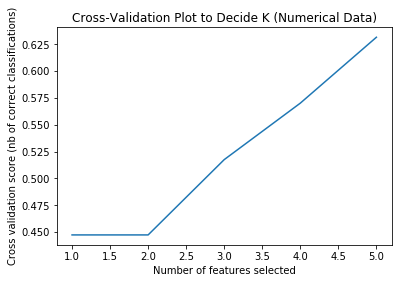

Original number of features: 5

These are the 5 recommended numerical features:

['mean', 'std', 'max', 'min', 'update_rate']


In [4]:
##########################################################################
######################## NUMERICAL FEATURE SELECTION #####################
##########################################################################

##########################################################################
###################### Preprocessing of Data #############################
##########################################################################
numerical=merged_outer[['mean','std','max','min','update_rate','endUseLabel']]
numerical=numerical.dropna(axis=0) # drop rows if they contain nan for enduselabel, because not part of training data
dataset = numerical.values
X = pd.DataFrame(dataset[:, :-1], columns=numerical.columns[0:5])
y = dataset[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
##########################################################################
################### Done with Preprocessing of Data ######################
##########################################################################


##########################################################################
################# Choosing K through Cross-Validation ####################
##########################################################################
rfc = RandomForestClassifier(random_state=101)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(2), scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title("Cross-Validation Plot to Decide K (Numerical Data)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
##########################################################################
###################### Done with Cross-Validation ########################
##########################################################################



##########################################################################
#################  ANOVA F-Score Technique using K #######################
##########################################################################
fvalue_selector = SelectKBest(f_classif, k=rfecv.n_features_)
# Apply the SelectKBest object to the features and target
X_kbest = fvalue_selector.fit_transform(X, y)
# Create and fit selector
cols = fvalue_selector.get_support(indices=True)
numerical_features=X.iloc[:,cols].columns.tolist()
# Show results
print('Original number of features:', X.shape[1])
print('')
print('These are the {:.0f} recommended numerical features:'.format(X.shape[1]))
print('')
print(numerical_features)
##########################################################################
############################ Done with ANOVA #############################
##########################################################################